# 参数初始化、优化器和正则化方法

在前面的教程中，我们学习了基本的`pytorch`使用方法，以及如何搭建一个简单的MLP用于图像分类任务。

本次我们将了解如何初始化模型的参数、使用不同的优化器、L2正则和dropout(丢弃法)等正则化方法。


## 0. 数据准备和包的安装

从[这里](https://cloud.tsinghua.edu.cn/f/54b0d014fad4457aa613/?dl=1)下载数据文件`mnist.pkl`，并和本文档放在同一个目录中。

后面我们需要用到`torch`(机器学习框架)、`matplotlib`(绘图)、`tqdm`(进度条)这三个包，`torch`应该已经安装过了，后面两个如果没有装过，可以在激活conda环境后用如下命令安装：

`conda install matplotlib -y`

`conda install tqdm -y`

如果一切顺利，运行下面的单元格不会有任何问题。

In [1]:
import torch
from torch import nn
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import numpy as np

In [2]:
# 加载数据
data,label=pickle.load(open('mnist.pkl','rb'))

In [22]:
# data包含了一堆28x28的图像，label则是它们对应的标签
print(data.shape)
print(label)

torch.Size([60000, 28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])


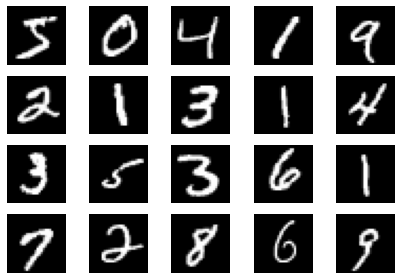

In [23]:
# 可视化看一下data
for i in range(4):
    for j in range(5):
        n=i*5+j
        # 子图
        plt.subplot(4,5,n+1)
        # 以灰度显示
        plt.imshow(data[n],cmap='gray')
        # 不显示xy轴
        plt.axis('off')
plt.tight_layout()

# 1. 模型参数初始化

线性层的数学形式可以写为$f(x)=g(Wx+b)$，其中$g(\cdot)$是激活函数，权重$W$和偏置$b$是参数。

一般来说，$b$初始化为0，$W$初始化为随机数，比如每个元素都从正态分布$N(0,1)$中抽取。

In [24]:
class Linear(nn.Module):
    def __init__(self, N, M, std=1):
        # super()返回的是父类，即nn.Module，调用它的__init__函数才能让我们的类能够正常工作
        # 更多super()相关知识：https://rhettinger.wordpress.com/2011/05/26/super-considered-super/
        super().__init__()
        # 生成标准差为std的正态分布随机数矩阵
        self.W=torch.randn((M,N))*std
        self.b=torch.zeros(M)
    def forward(self,x):
        # 这里为了简单起见省略了激活函数
        return self.W@x+self.b

对于深层模型，这样的做法存在数值稳定性上的隐患。

考虑$n$层的模型，它的输出为$y=f(\cdots f(x)\cdots)=f^{(n)}(x)\approx \alpha^n W^n x$，这里的$\alpha$表示了激活函数对输入在尺度上的影响。显然，当$n$很大时，$y$要么趋于0（$|\alpha W|<1$）要么趋于无穷（$|\alpha W|>1$）。

In [25]:
# 10层的模型
model=[Linear(5,5) for _ in range(10)]
x=torch.randn(5)
y=x
for layer in model:
    y=layer(y)
print(x)
print(y)

tensor([ 0.9510,  0.4655,  0.8457, -1.0197,  0.1475])
tensor([  797.4415, -1748.1294,  -934.4637, -2585.7378, -1624.4749])


可见，$x$在经过了10层线性层之后输出的$y$变得很大，由于计算机所能表示的数值存在精度上限和下限，这样会影响模型的训练。

为了避免这种情况出现，一个简单但有效的手段是调整初始化时随机变量的方差，使得每一层的**输出值的方差**和**输入值的方差**相同。假设$W\in \mathbb{R}^{M\times N}$的每一项的方差为$\sigma_W^2$，$y=Wx$，那么$y_i$的方差是$x_i$的$N\sigma_W^2$倍，于是我们可以取$\sigma_W=\sqrt{1/N}$使得方差不变。

In [26]:
model=[Linear(5,5,std=(1/5)**0.5) for _ in range(10)]
y=x
for layer in model:
    y=layer(y)
print(x)
print(y)

tensor([ 0.9510,  0.4655,  0.8457, -1.0197,  0.1475])
tensor([ 0.1454, -0.1263, -0.0977, -0.0716, -0.0058])


可见此时$y$的值位于合理范围内了。

如果考虑激活函数的影响，也就是前面写的系数$\alpha$，问题会复杂一点，需要根据激活函数的类型选取合适的$\alpha$值进行补偿，`nn.init.calculate_gain`函数提供了这一功能。

In [27]:
# ReLU的补偿系数是√2
nn.init.calculate_gain('relu')

1.4142135623730951

最后说明一下，`pytorch`中提供的`nn.Linear`等层都自带合理的初始化，使用这些层时不需要额外考虑初始化问题。

In [28]:
model=[nn.Linear(5,5) for _ in range(10)]
y=x
for layer in model:
    y=layer(y)
print(x)
print(y)

tensor([ 0.9510,  0.4655,  0.8457, -1.0197,  0.1475])
tensor([-0.4660, -0.2087,  0.2535, -0.4151,  0.3937], grad_fn=<AddBackward0>)


# 2. 优化器

SGD是最基础的优化器，此外还有一些引入了动量项的能够更快收敛的优化器，如RMSprop、Adam等。

这些常用的优化器在`torch.optim`中都有提供（[完整列表](https://pytorch.org/docs/stable/optim.html#algorithms)），下面我们测试一下它们的效果。

In [29]:
# 定义模型
model=nn.Sequential(
    # 输入是Nx28x28的，将这后两维展开便于线性层处理
    nn.Flatten(),           
    # 模型就是简单的 “线性层-激活函数-线性层-……” 这样的配置
    nn.Linear(28*28,100),   
    nn.ReLU(),
    nn.Linear(100,50),
    nn.ReLU(),
    # 最后的输出是10维的
    # 对于我们这个分类任务，每一维的数值代表了模型对输入图像属于对每一类的打分
    # 这个数值的绝对大小和范围没有意义，所以不需要再加sigmoid、softmax之类的限制输出范围
    nn.Linear(50,10)        
)

In [30]:
# 定义训练函数
def train(data, label, model, optim):
    # 优化器
    optim=optim(model.parameters(), lr=0.005)
    # 设置使用交叉熵损失
    criterion=nn.CrossEntropyLoss()
    # 设置批处理大小
    batch_size=300
    # 记录损失的变化
    losses=[]
    # 用tqdm显示一个进度条
    with tqdm(range(10)) as tq:
        for _ in tq:
            for i in range(0,len(data),batch_size):
                # 选取一批数据
                x=data[i:i+batch_size]
                target=label[i:i+batch_size]
                y=model(x)
                # 算损失
                loss=criterion(y,target)
                # 清除梯度、反向传播、更新参数
                optim.zero_grad()
                loss.backward()
                optim.step()
                # 记录loss
                losses.append(loss.item())
                if i%6000==0:
                    tq.set_description(f'loss={loss.item():.4f}')
    return losses

In [31]:
# 测试使用不同的优化器训练的效果
loss_sgd=train(data,label,copy.deepcopy(model),torch.optim.SGD)
loss_rmsprop=train(data,label,copy.deepcopy(model),torch.optim.RMSprop)
loss_adam=train(data,label,copy.deepcopy(model),torch.optim.Adam)

loss=0.0438: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


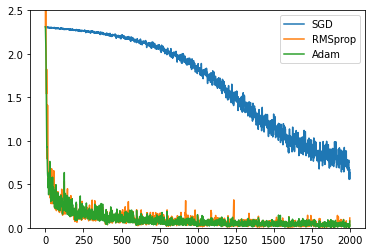

In [32]:
# 画图
plt.plot(np.array([loss_sgd,loss_rmsprop,loss_adam]).T)
plt.ylim([0,2.5])
plt.legend(['SGD','RMSprop','Adam'])
plt.show()

可以看到`RMSprop`和`Adam`这样的带动量的方法在初期能够让loss下降得更快。

# 3. 过拟合与正则化

一般来说，由于深度学习模型的参数多、表示能力强，在训练过程中模型可能会尝试过于精确地拟合训练数据中的误差，导致在测试集上的泛化能力不强。

我们可以通过一个简单的例子来直观地感受一下过拟合现象。

In [33]:
# 取一部分作为训练集和测试集
data_train=data[:100]
label_train=label[:100]
data_test=data[100:200]
label_test=label[100:200]

loss=0.0001: 100%|██████████| 1000/1000 [00:11<00:00, 87.47it/s]


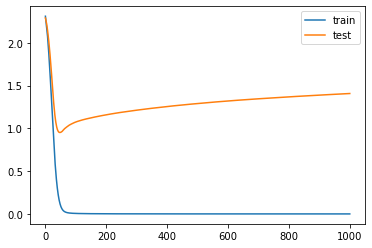

In [34]:
# 训练模型并记录损失
m=copy.deepcopy(model)
optim=torch.optim.Adam(m.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
loss_train=[]
loss_test=[]
with tqdm(range(1000)) as tq:
    for _ in tq:
        y=m(data_train)
        loss=criterion(y,label_train)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            loss_train.append(loss.item())
            loss_test.append(criterion(m(data_test),label_test))
            tq.set_description(f'loss={loss.item():.4f}')
# 绘图
plt.plot(np.array([loss_train,loss_test]).T)
plt.legend(['train','test'])

可以看到模型在测试集上的损失先下降再上升。为了缓解过拟合问题，我们可以尝试一些正则化方法。

### 方法1：对模型参数增加$L_1$或者$L_2$正则项。

对于线性层来说，一般正则项只作用于权重$W$而不作用于偏置$b$，因此新的损失函数可以写为

$loss=\cdots+\lambda \sum |W|^2$

其中$\lambda$控制了正则项的强度。

loss=0.0529: 100%|██████████| 1000/1000 [00:12<00:00, 82.53it/s]


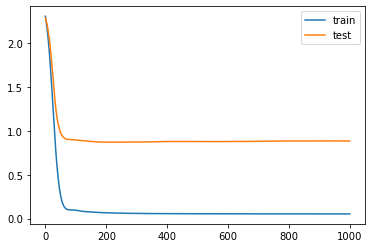

In [35]:
m=copy.deepcopy(model)

# 用named_parameters遍历模型的参数列表，从中选出权重参数
weights=[param for name, param in m.named_parameters() if name.endswith('weight')]

optim=torch.optim.Adam(m.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
loss_train=[]
loss_test=[]
with tqdm(range(1000)) as tq:
    for _ in tq:
        y=m(data_train)
        loss=criterion(y,label_train)

        # 在loss中添加权重的L2范数正则项，|w|还是|w|²都无所谓
        loss2=loss+0.01*sum(torch.sum(w*w) for w in weights)

        optim.zero_grad()
        loss2.backward()
        optim.step()
        with torch.no_grad():
            loss_train.append(loss.item())
            loss_test.append(criterion(m(data_test),label_test))
            tq.set_description(f'loss={loss.item():.4f}')
plt.plot(np.array([loss_train,loss_test]).T)
plt.legend(['train','test'])

上面的代码相比之前只增加了带注释的那两行。可见增加L2正则项有效地抑制了过拟合现象。

### 方法2：权重衰减

`torch.optim`中的优化器都提供了`weight_decay`这一参数，可以直接使用。

loss=0.0261: 100%|██████████| 1000/1000 [00:10<00:00, 94.92it/s]


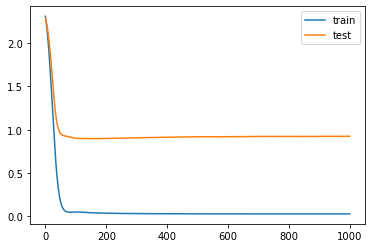

In [36]:
m=copy.deepcopy(model)

# 在构造函数中传入weight_decay参数（默认值是0）
optim=torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.01)

criterion=nn.CrossEntropyLoss()
loss_train=[]
loss_test=[]
with tqdm(range(1000)) as tq:
    for _ in tq:
        y=m(data_train)
        loss=criterion(y,label_train)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            loss_train.append(loss.item())
            loss_test.append(criterion(m(data_test),label_test))
            tq.set_description(f'loss={loss.item():.4f}')
plt.plot(np.array([loss_train,loss_test]).T)
plt.legend(['train','test'])

### 方法3：增加Dropout层

Dropout层就是以一定概率$p$将输入值的一部分置零，`pytorch`提供了`nn.Dropout`这一函数用于创建Dropout层，但为了更好地理解原理，下面我们手动实现一个。

需要注意几点问题：
1. 我们要区分训练(train)与评估(eval)这两个阶段，在评估时不应该再做dropout
2. 在训练时除以$1-p$或者在评估时乘以$1-p$，使得做与不做dropout时输出的期望不变
3. ~~要记录哪些地方被置零了，在反向传播时这些地方不要传梯度~~（`pytorch`有自动梯度所以无需考虑）

In [37]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        # 不要忘了写这一行
        super().__init__()
        self.p=p
    def forward(self, x):
        # self.training在调用model.eval()后变为False，在调用model.train()后变为True
        # 可以用此区分训练与评估阶段
        if self.training:
            # rand_like可以创建和x大小、类型都相同的随机数矩阵
            # 类似的函数还有zeros_like、ones_like、empty_like，创建全0、全1、未初始化矩阵
            # .to(x.dtype)将mask转换为与x同类型，避免在二者相乘时因为类型不同而出错
            mask=(torch.rand_like(x)>self.p).to(x.dtype)
            # 这里我们采用训练时除以1-p、测试时不做处理的方法
            return x*mask/(1-self.p)
        else:
            return x

Dropout层的作用主要体现在能够提升模型在测试集上的准确率，下面我们来验证这一点。

In [38]:
# 模型1
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,200),
    nn.ReLU(),
    nn.Linear(200,100),
    nn.ReLU(),
    nn.Linear(100,10)
)
# 模型2：在模型1的基础上添加dropout
model_dropout=nn.Sequential(
    nn.Flatten(),
    Dropout(0.2), # 一般来说对于输入层dropout取比较小的值
    nn.Linear(28*28,200),
    nn.ReLU(),
    Dropout(0.5), # 在之后的线性层输出部分可以用0.5的dropout
    nn.Linear(200,100),
    nn.ReLU(),
    Dropout(0.5), # 同上
    nn.Linear(100,10)
)

In [39]:
data_train=data[:1000]
label_train=label[:1000]
data_test=data[1000:2000]
label_test=label[1000:2000]
def train_and_get_acc(model):
    model=copy.deepcopy(model)
    optim=torch.optim.Adam(model.parameters(), lr=0.001)
    criterion=nn.CrossEntropyLoss()
    acc_train=[]
    acc_test=[]
    with tqdm(range(1000)) as tq:
        for _ in tq:
            y=model(data_train)
            loss=criterion(y,label_train)
            optim.zero_grad()
            loss.backward()
            optim.step()
            with torch.no_grad():
                # 前面提到，模型的输出是Nx10的，表示对输入图像属于0~9中每个类别的打分
                # 我们可以用y.max(1).indices获取每一行的最大值的下标，即模型认为图像最有可能属于的类别
                # .max(1)的含义是在1这个轴上取最大值，对于二维矩阵，0是列，1是行
                # .indices表示获取下标，用.values则是获取值
                # 这里用.to(float)是因为==给出的结果是bool类型无法求平均数
                acc_train.append((y.max(1).indices==label_train).to(float).mean())
                # 让模型进入评估状态
                model.eval()
                acc_test.append((model(data_test).max(1).indices==label_test).to(float).mean())
                # 让模型进入训练状态
                model.train()
                tq.set_description(f'loss={loss.item():.4f}')
    return model,acc_train,acc_test

loss=0.0082: 100%|██████████| 1000/1000 [01:40<00:00,  9.90it/s]


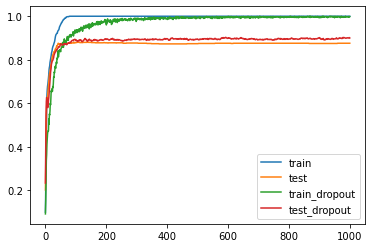

In [40]:
m_1,acc_train_1,acc_test_1=train_and_get_acc(model)
m_2,acc_train_2,acc_test_2=train_and_get_acc(model_dropout)
plt.plot(np.array([acc_train_1,acc_test_1,acc_train_2,acc_test_2]).T)
plt.legend(['train','test','train_dropout','test_dropout'])

可见使用dropout的模型在测试集上的准确度略有提升；这个例子中我们的模型比较简单，如果应用在更复杂的模型上，差距会更加明显一些。

# 4. 可视化

最后，我们看一下使用Softmax激活函数及交叉熵损失训练出的模型的可视化效果。

In [6]:
# 为了拿到模型中间的输出，我们将模型分为part_1和part_2两部分
# part_1的输出是二维的，便于可视化
part_1=nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,200),
    nn.ReLU(),
    nn.Linear(200,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
part_2=nn.Linear(2,10)
model=nn.Sequential(
    part_1,
    part_2
)

In [7]:
data_train=data[:1000]
label_train=label[:1000]

optim=torch.optim.Adam(model.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
for _ in tqdm(range(1000)):
    y=model(data_train)
    loss=criterion(y,label_train)
    optim.zero_grad()
    loss.backward()
    optim.step()

100%|██████████| 1000/1000 [00:06<00:00, 149.53it/s]


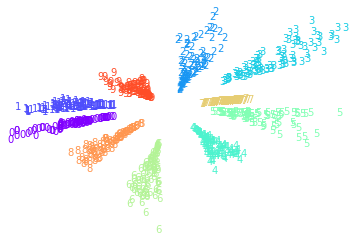

In [14]:
with torch.no_grad():
    y=part_1(data_train).numpy()
# 简单归一化一下
y=(y-y.min(0))/(y.max(0)-y.min(0))
# 画图
for (i,j),label,color in zip(y,label_train.numpy(),plt.cm.rainbow(label_train/10)):
    plt.text(i,j, s=str(label), color=color)
plt.axis('off')
plt.show()

可见不同类别之间的区分较为明显，呈现三角锥形排列。